%md
<h1> MARKET BASKET ANALYSIS USING APRIORI AND FP-GROWTH ALGORITHMS </h1>


In [0]:

from pyspark.sql.functions import col, collect_set, trim, array_remove,array_contains, lit, size, count,desc , explode, split,rank
from pyspark.sql.types import StructType, StructField, ArrayType, StringType
from pyspark.ml.fpm import FPGrowth
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import seaborn as sns
from pyspark.sql import DataFrame
from pyspark import SparkContext
from itertools import chain, combinations
from pyspark.sql import SparkSession 
from pyspark.sql.window import Window


%md
<h2> DATA LOADING </h2>


In [0]:
file_path = "/FileStore/tables/data-2.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)


<h2> DATA PREPROCESSING </h2>


In [0]:
#Remove spaces before and after description
df = df.withColumn('Description', trim(col('Description')))

#Drop rows with null invoiceNo
df = df.dropna(subset=['InvoiceNo'])

#Convrt invoiceNo to string
df = df.withColumn('InvoiceNo', col('InvoiceNo').cast('string'))

#Filter out canceled transactions (those containing C)
df = df.filter(~df['InvoiceNo'].contains('C'))

#Drop unnecessary columns not needed
df = df.drop('StockCode', 'InvoiceDate', 'UnitPrice', 'CustomerID')


In [0]:
df.describe()

Out[4]: DataFrame[summary: string, InvoiceNo: string, Description: string, Quantity: string, Country: string]

In [0]:

df.describe("Quantity").show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            532621|
|   mean|10.239971762285002|
| stddev| 159.5935513190853|
|    min|             -9600|
|    max|             80995|
+-------+------------------+



In [0]:

df.select([count(col(c).isNull()).alias(c) for c in df.columns]).show()

df = df.dropna()

print(f"DataFrame Shape after removing nulls: ({df.count()}, {len(df.columns)})")

+---------+-----------+--------+-------+
|InvoiceNo|Description|Quantity|Country|
+---------+-----------+--------+-------+
|   532621|     532621|  532621| 532621|
+---------+-----------+--------+-------+

DataFrame Shape after removing nulls: (531167, 4)


%md
<h2> TOTAL TRANSACTIONS BY COUNTRY </h2>


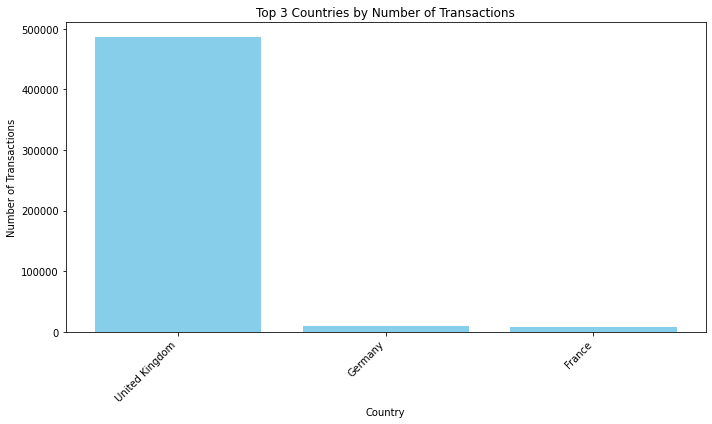

In [0]:

country_counts = df.groupBy("Country").count().orderBy(desc("count"))

top3_countries = country_counts.limit(3).toPandas()

plt.figure(figsize=[10, 6])
plt.bar(top3_countries['Country'], top3_countries['count'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Top 3 Countries by Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [0]:
print(top3_countries)

          Country   count
0  United Kingdom  486168
1         Germany    9042
2          France    8408


%md
<h2> MOST SOLD ITEMS IN DATASET </h2>


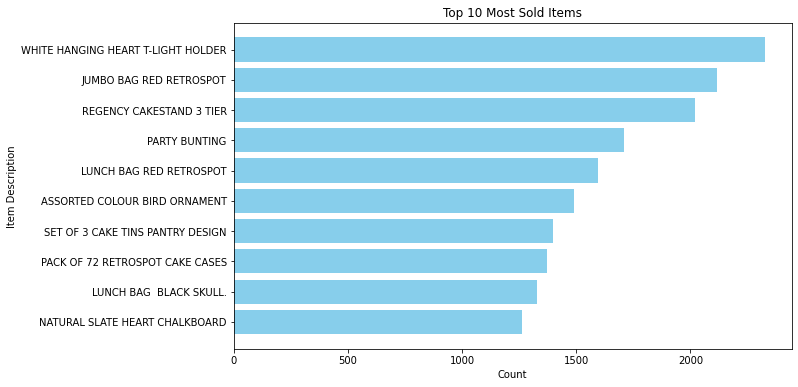

In [0]:

most_sold = df.groupBy('Description').count().orderBy(desc('count'))
most_sold_top_10 = most_sold.limit(10)
most_sold_pd = most_sold_top_10.toPandas()


plt.figure(figsize=(10, 6))
plt.barh(most_sold_pd['Description'], most_sold_pd['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.title('Top 10 Most Sold Items')
plt.gca().invert_yaxis()
plt.show()


%md
<h1> FP-GROWTH </h1>


In [0]:

baskets = df.groupBy("InvoiceNo").agg(collect_set("Description").alias("items"))

uk_basket = df.filter(df['Country'] == 'United Kingdom').groupBy("InvoiceNo").agg(collect_set("Description").alias("items"))
germany_basket = df.filter(df['Country'] == 'Germany').groupBy("InvoiceNo").agg(collect_set("Description").alias("items"))
france_basket = df.filter(df['Country'] == 'France').groupBy("InvoiceNo").agg(collect_set("Description").alias("items"))

uk_basket = uk_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))
germany_basket = germany_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))
france_basket = france_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))


In [0]:
def get_association_rules(basket_df, min_support=0.03, min_confidence=0.5):
    fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
    model = fp_growth.fit(basket_df)
    
    freq_itemsets = model.freqItemsets
    rules = model.associationRules
    return freq_itemsets, rules

In [0]:
uk_freq_itemsets, uk_rules = get_association_rules(uk_basket)
germany_freq_itemsets, germany_rules = get_association_rules(germany_basket)
france_freq_itemsets, france_rules = get_association_rules(france_basket)


%md
<h2> FP-GROWTH VISUALIZATION</h2>

In [0]:

uk_rules_df = uk_rules.toPandas()
germany_rules_df = germany_rules.toPandas()
france_rules_df = france_rules.toPandas()

def plot_top_rules(rules_df, metric, title):
    top_rules = rules_df.nlargest(10, metric)
    rule_labels = [f"{list(antecedent)} -> {list(consequent)}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])]
    plt.figure(figsize=(14, 12))
    colors = plt.cm.Paired(range(len(top_rules)))
    patches, texts, autotexts = plt.pie(top_rules[metric], autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 14})
    plt.legend(patches, rule_labels, title='Rules', loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
    plt.axis('equal')
    plt.title(f'Top 10 Association Rules by {metric} in {title}')
    plt.show()

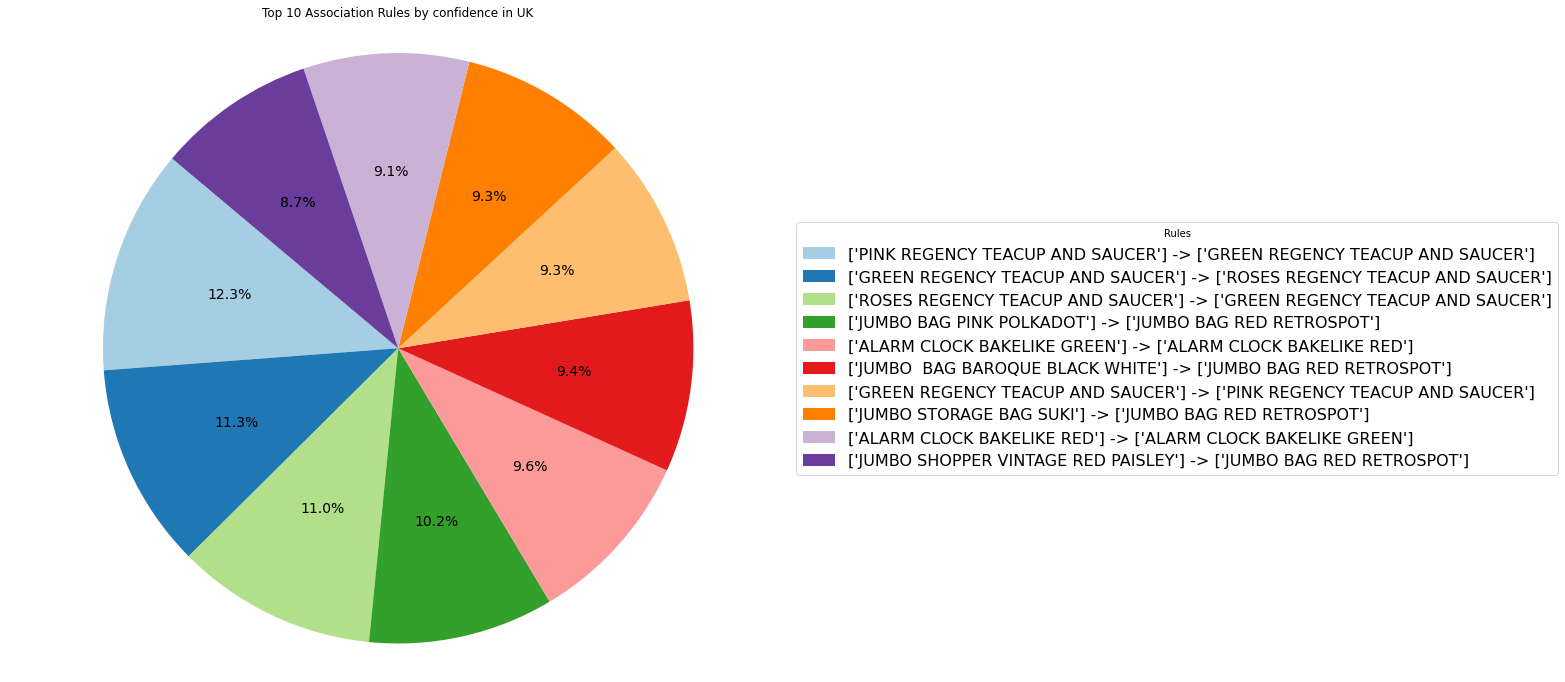

In [0]:
plot_top_rules(uk_rules_df, 'confidence', 'UK')

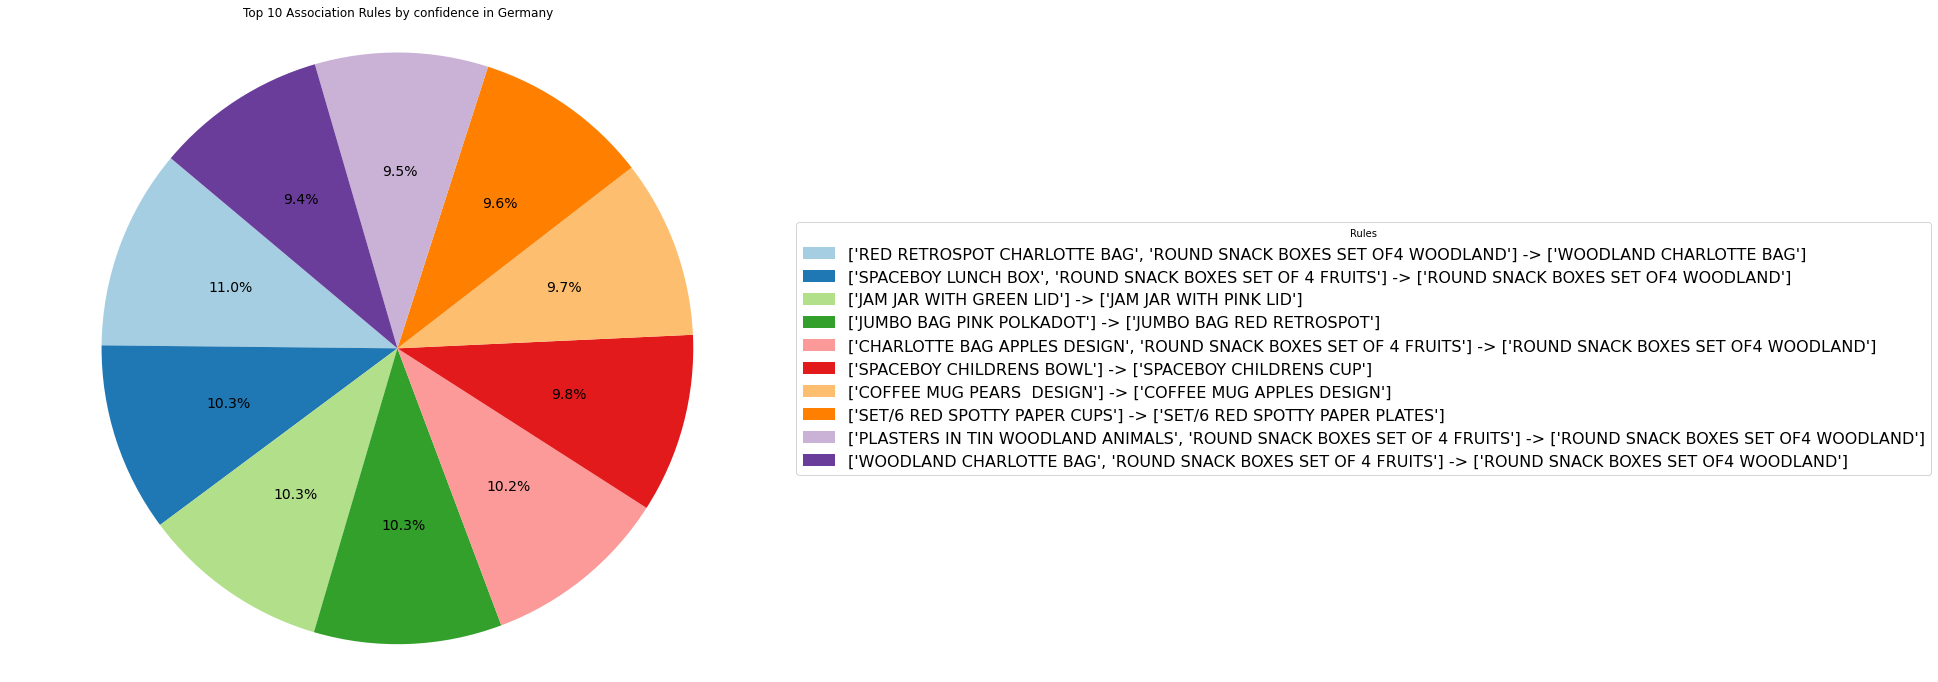

In [0]:

plot_top_rules(germany_rules_df, 'confidence', 'Germany')


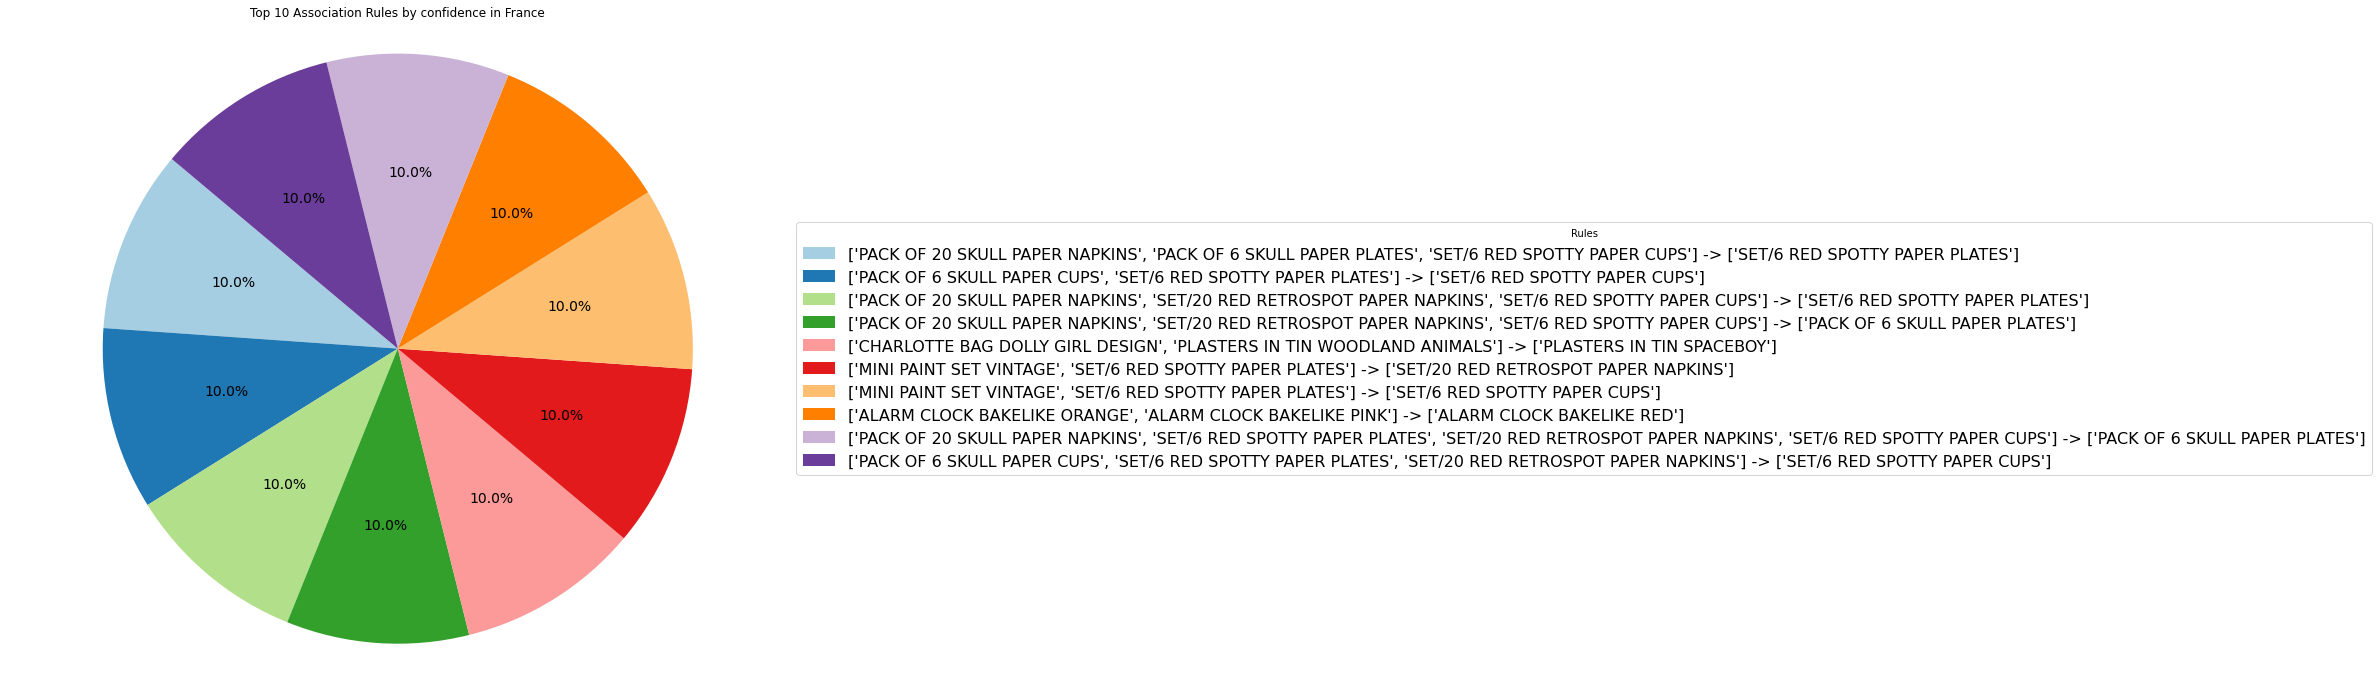

In [0]:

plot_top_rules(france_rules_df, 'confidence', 'France')

In [0]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=france_rules_df['support'],
    y=france_rules_df['confidence'],
    z=france_rules_df['lift'],
    mode='markers',
    marker=dict(color=france_rules_df['support'], size=8, colorscale='Viridis', opacity=0.8),
    text=[f"Support: {s}, Confidence: {c}, Lift: {l}" for s, c, l in zip(france_rules_df['support'], france_rules_df['confidence'], france_rules_df['lift'])]
)

fig.add_trace(scatter)
fig.update_layout(scene=dict(xaxis_title='Support', yaxis_title='Confidence', zaxis_title='Lift'))
fig.update_layout(title='Interactive 3D Scatter Plot of Support, Confidence, and Lift (FRANCE BASKET)')
fig.show()


In [0]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=germany_rules_df['support'],
    y=germany_rules_df['confidence'],
    z=germany_rules_df['lift'],
    mode='markers',
    marker=dict(color=germany_rules_df['support'], size=8, colorscale='Viridis', opacity=0.8),
    text=[f"Support: {s}, Confidence: {c}, Lift: {l}" for s, c, l in zip(germany_rules_df['support'], germany_rules_df['confidence'], germany_rules_df['lift'])]
)

fig.add_trace(scatter)
fig.update_layout(scene=dict(xaxis_title='Support', yaxis_title='Confidence', zaxis_title='Lift'))
fig.update_layout(title='Interactive 3D Scatter Plot of Support, Confidence, and Lift (GERMANY BASKET)')
fig.show()


In [0]:
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

scatter = go.Scatter3d(
    x=uk_rules_df['support'],
    y=uk_rules_df['confidence'],
    z=uk_rules_df['lift'],
    mode='markers',
    marker=dict(color=uk_rules_df['support'], size=8, colorscale='Viridis', opacity=0.8),
    text=[f"Support: {s}, Confidence: {c}, Lift: {l}" for s, c, l in zip(uk_rules_df['support'], uk_rules_df['confidence'], uk_rules_df['lift'])]
)

fig.add_trace(scatter)
fig.update_layout(scene=dict(xaxis_title='Support', yaxis_title='Confidence', zaxis_title='Lift'))
fig.update_layout(title='Interactive 3D Scatter Plot of Support, Confidence, and Lift (UK BASKET)')
fig.show()


In [0]:

def plot_heatmap(rules_df, title):

    top_rules = rules_df[
        (rules_df['lift'] >= 3) &
        (rules_df['confidence'] >= 0.5) &
        (rules_df['support'] >= 0.03)
    ].nlargest(10, 'confidence')

    
    top_rules['antecedent'] = top_rules['antecedent'].apply(tuple)
    top_rules['consequent'] = top_rules['consequent'].apply(tuple)

    
    top_rules_pivot = top_rules.pivot(index='antecedent', columns='consequent', values='confidence')

    
    plt.figure(figsize=(14, 12))
    sns.heatmap(top_rules_pivot, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Confidence'})
    plt.title(f'Top 10 Association Rules Heatmap based on Confidence - {title}')
    plt.xlabel('Consequents')
    plt.ylabel('Antecedents')
    plt.show()

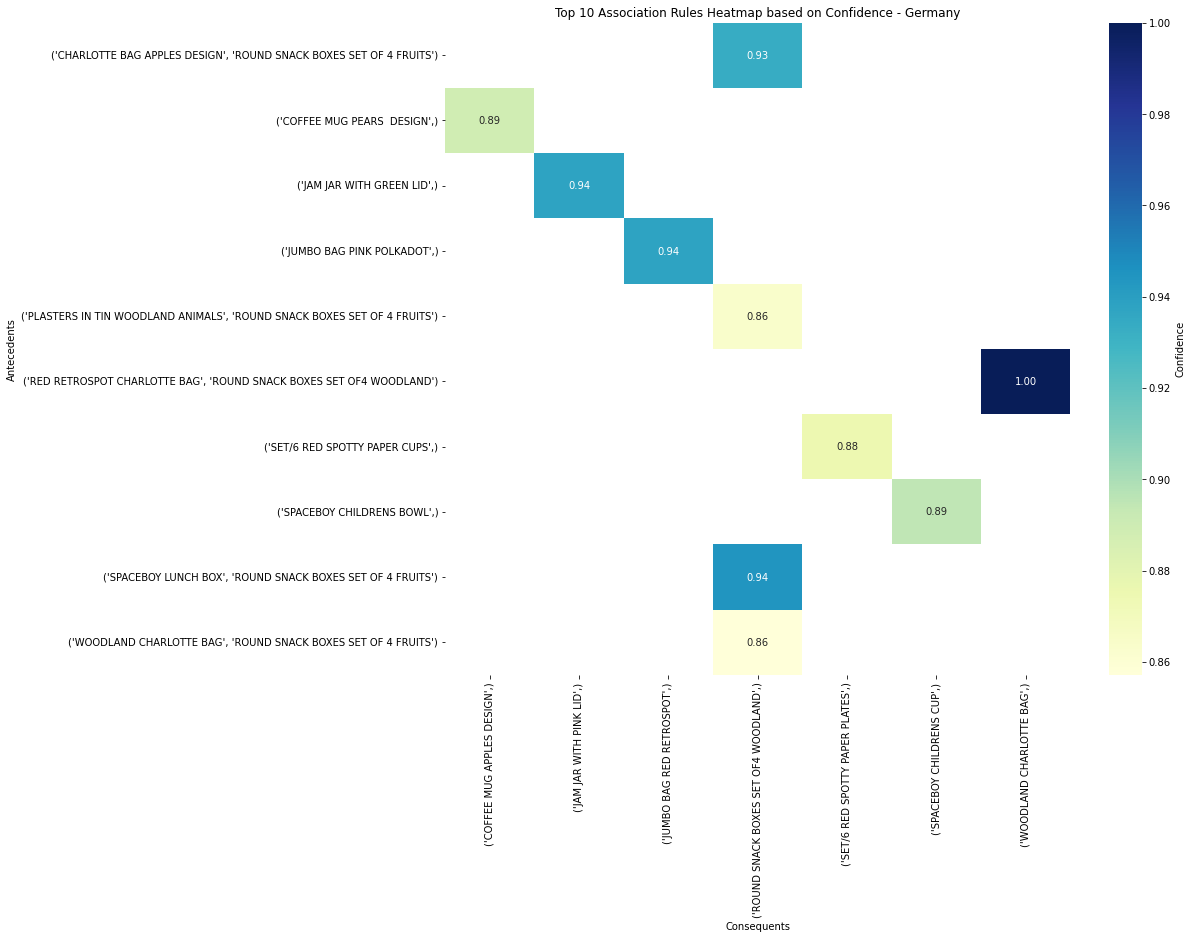

In [0]:

plot_heatmap(germany_rules_df, 'Germany')


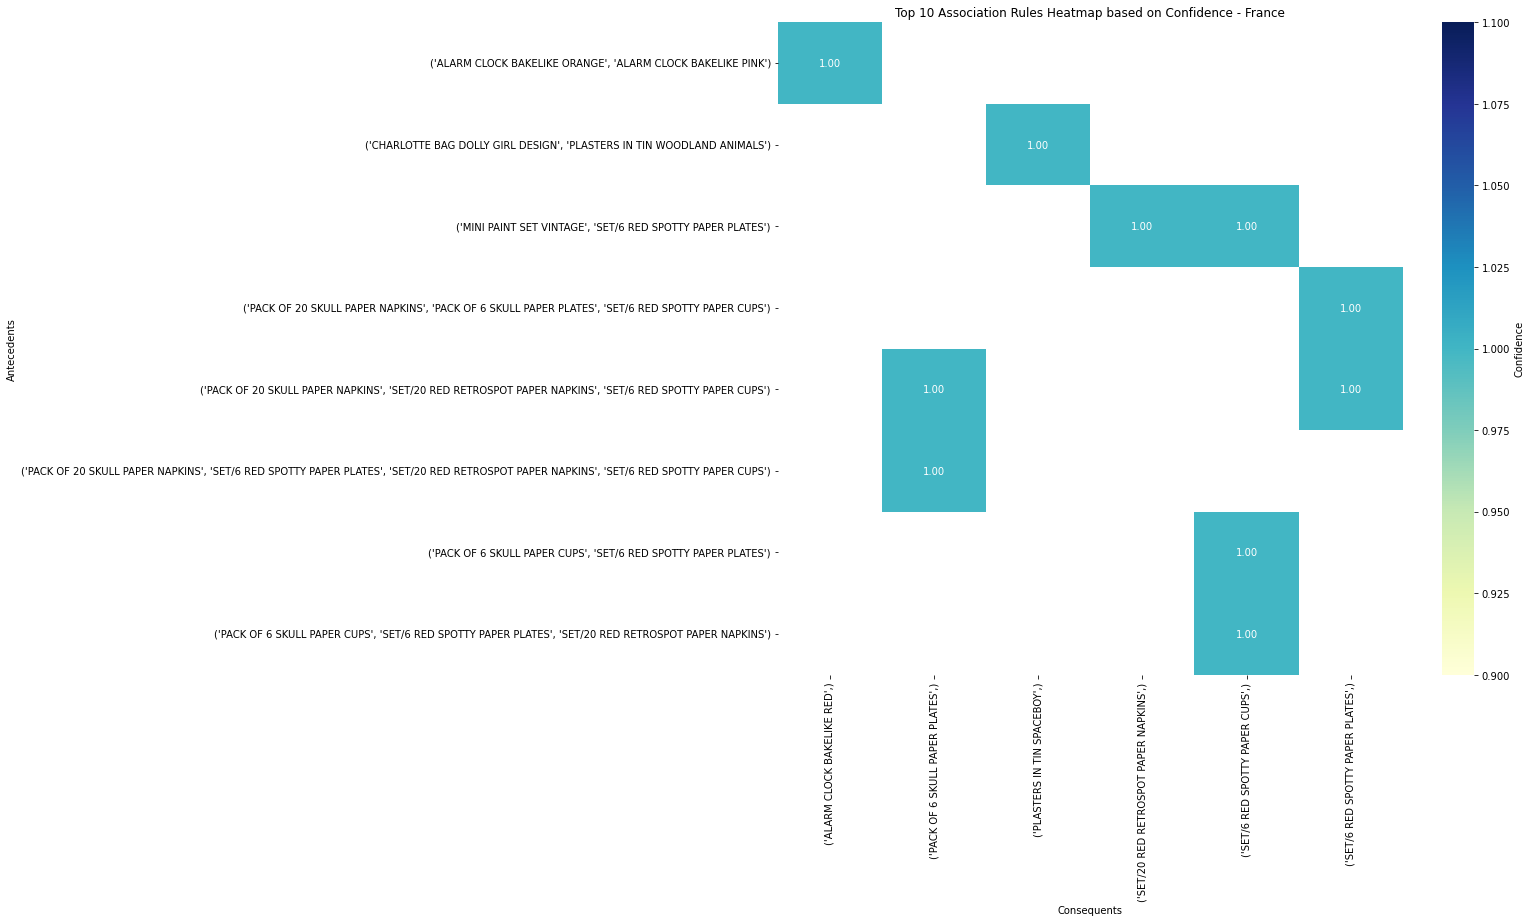

In [0]:
plot_heatmap(france_rules_df, 'France')

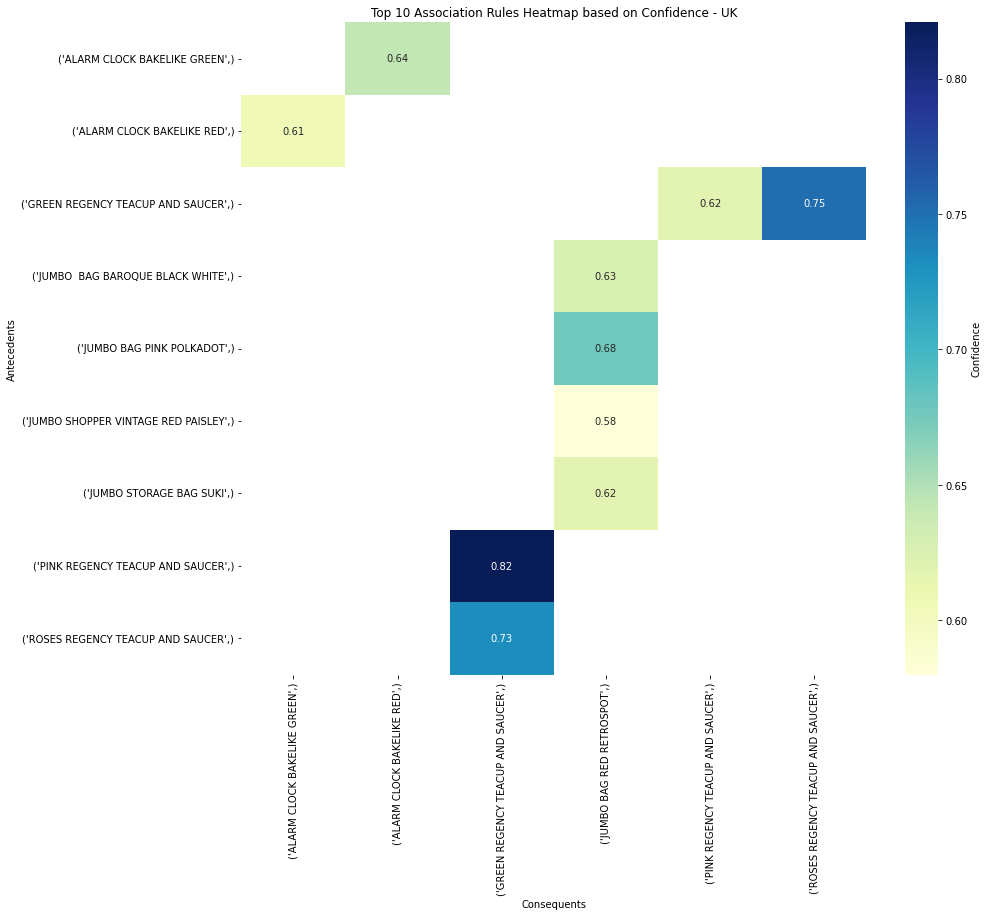

In [0]:
plot_heatmap(uk_rules_df, 'UK')

%md
<h1> APRIORI ALGORITHM </h1>


In [0]:

def apriori(basket_df: DataFrame, min_support=0.03):
    total_baskets = basket_df.count()
    min_support_count = total_baskets * min_support

    
    def generate_candidate_itemsets(itemsets, length):
        items = sorted(set(chain(*itemsets)))
        return [frozenset(itemset) for itemset in combinations(items, length)]

   
    def calculate_support(itemsets, baskets):
        itemset_counts = {itemset: 0 for itemset in itemsets}
        for basket in baskets:
            for itemset in itemsets:
                if itemset.issubset(basket):
                    itemset_counts[itemset] += 1
        return {itemset: count for itemset, count in itemset_counts.items() if count >= min_support_count}

   
    items = basket_df.select(explode(col("items")).alias("item")).distinct().rdd.map(lambda row: frozenset([row[0]])).collect()
    
    
    baskets = basket_df.select("items").rdd.map(lambda row: set(row[0])).collect()

    
    frequent_itemsets = []
    current_itemsets = items
    k = 1

    while current_itemsets:
        
        current_frequent_itemsets = calculate_support(current_itemsets, baskets)
        
        
        if not current_frequent_itemsets:
            break
        
        frequent_itemsets.extend(current_frequent_itemsets.keys())
        
        
        k += 1
        current_itemsets = generate_candidate_itemsets(current_frequent_itemsets.keys(), k)

    return frequent_itemsets



uk_basket = uk_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))
germany_basket = germany_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))
france_basket = france_basket.withColumn('items', array_remove(col('items'), 'POSTAGE'))


uk_freq_itemsets_apriori = apriori(uk_basket)
germany_freq_itemsets_apriori = apriori(germany_basket)
france_freq_itemsets_apriori = apriori(france_basket)



In [0]:


def calculate_metrics(itemsets, baskets):
    metrics = []
    basket_count = len(baskets)
    for itemset in itemsets:
        support = sum(1 for basket in baskets if itemset.issubset(basket)) / basket_count
        for item in itemset:
            antecedent = itemset - frozenset([item])
            consequent = frozenset([item])
            if antecedent:
                antecedent_support = sum(1 for basket in baskets if antecedent.issubset(basket)) / basket_count
                confidence = support / antecedent_support
                lift = confidence / (sum(1 for basket in baskets if consequent.issubset(basket)) / basket_count)
                metrics.append((antecedent, consequent, support, confidence, lift))
    return metrics


def convert_to_pandas(frequent_itemsets, baskets):
    metrics = calculate_metrics(frequent_itemsets, baskets)
    df = pd.DataFrame(metrics, columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])
    return df


def plot_top_rules(rules_df, metric, title):
    top_rules = rules_df.nlargest(10, metric)
    rule_labels = [f"{list(antecedent)} -> {list(consequent)}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])]
    
    plt.figure(figsize=(10, 6))
    plt.barh(rule_labels, top_rules[metric], color='skyblue')
    plt.xlabel(metric.capitalize())
    plt.ylabel('Rules')
    plt.title(f"Top 10 Rules by {metric.capitalize()} - {title}")
    plt.show()

def plot_3d_scatter(rules_df, title):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    scatter = go.Scatter3d(
        x=rules_df['support'],
        y=rules_df['confidence'],
        z=rules_df['lift'],
        mode='markers',
        marker=dict(color=rules_df['support'], size=8, colorscale='Viridis', opacity=0.8),
        text=[f"Support: {s}, Confidence: {c}, Lift: {l}" for s, c, l in zip(rules_df['support'], rules_df['confidence'], rules_df['lift'])]
    )
    fig.add_trace(scatter)
    fig.update_layout(title=title, scene=dict(
        xaxis_title='Support',
        yaxis_title='Confidence',
        zaxis_title='Lift'
    ))
    fig.show()


uk_baskets = uk_basket.select("items").rdd.map(lambda row: set(row[0])).collect()
germany_baskets = germany_basket.select("items").rdd.map(lambda row: set(row[0])).collect()
france_baskets = france_basket.select("items").rdd.map(lambda row: set(row[0])).collect()


uk_rules_df_apriori = convert_to_pandas(uk_freq_itemsets_apriori, uk_baskets)
germany_rules_df_apriori = convert_to_pandas(germany_freq_itemsets_apriori, germany_baskets)
france_rules_df_apriori = convert_to_pandas(france_freq_itemsets_apriori, france_baskets)





<h2> APRIORI VISUALIZATION </h2>


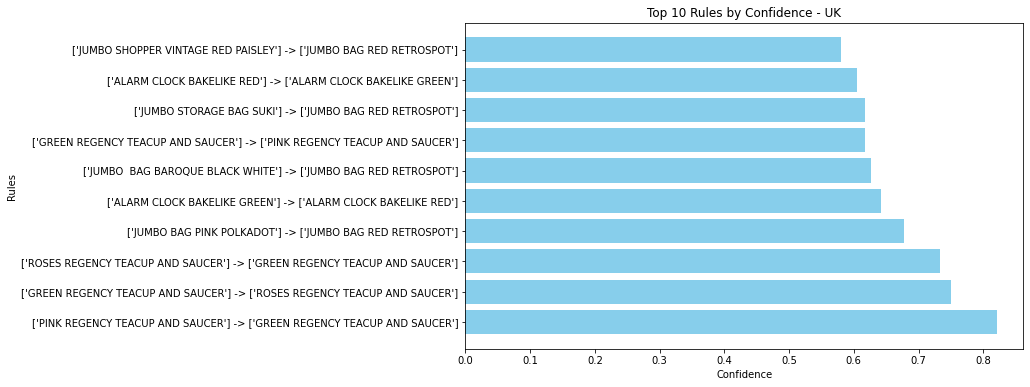

In [0]:
plot_top_rules(uk_rules_df_apriori, 'confidence', 'UK')

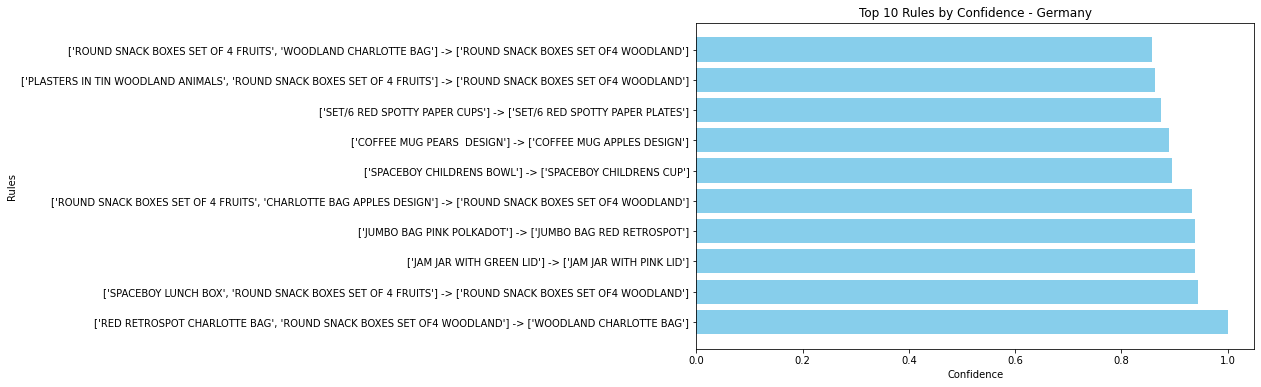

In [0]:
plot_top_rules(germany_rules_df_apriori, 'confidence', 'Germany')


In [0]:
plot_top_rules(france_rules_df_apriori, 'confidence', 'France')

In [0]:
plot_3d_scatter(uk_rules_df_apriori, 'UK Rules')

In [0]:
plot_3d_scatter(germany_rules_df_apriori, 'Germany Rules')

In [0]:
plot_3d_scatter(france_rules_df_apriori, 'France Rules')

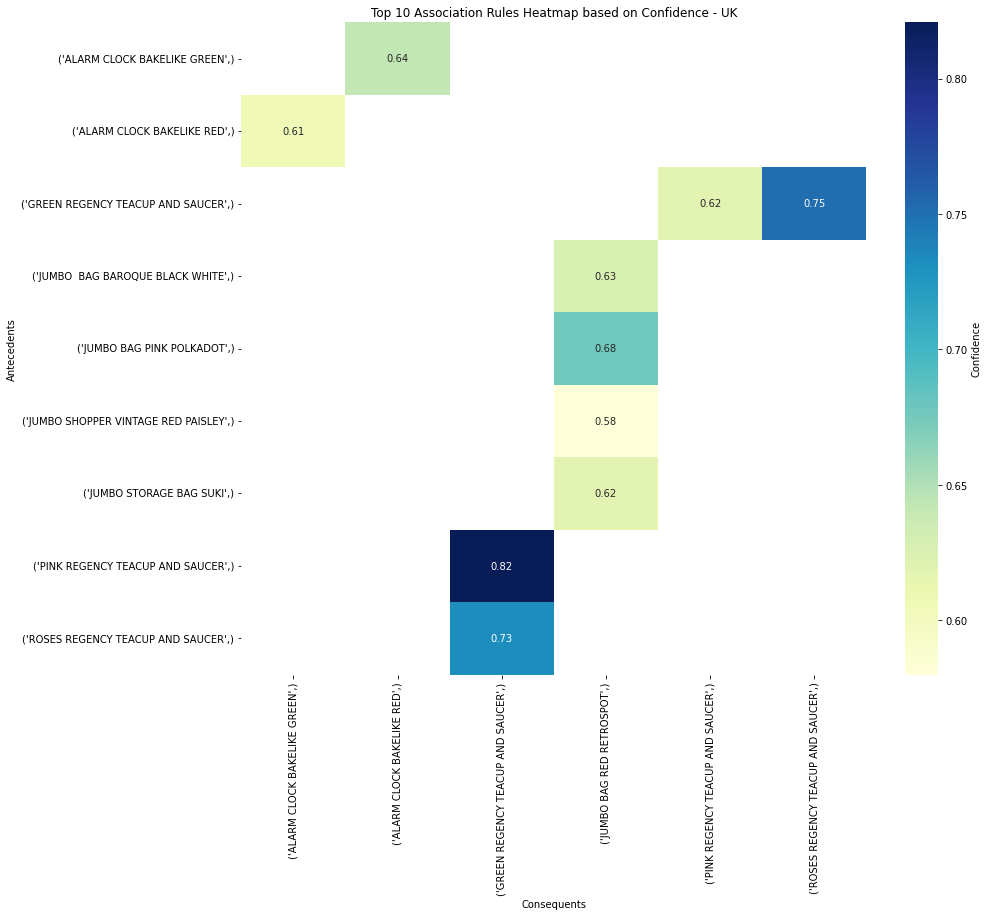

In [0]:

plot_heatmap(uk_rules_df_apriori, 'UK')


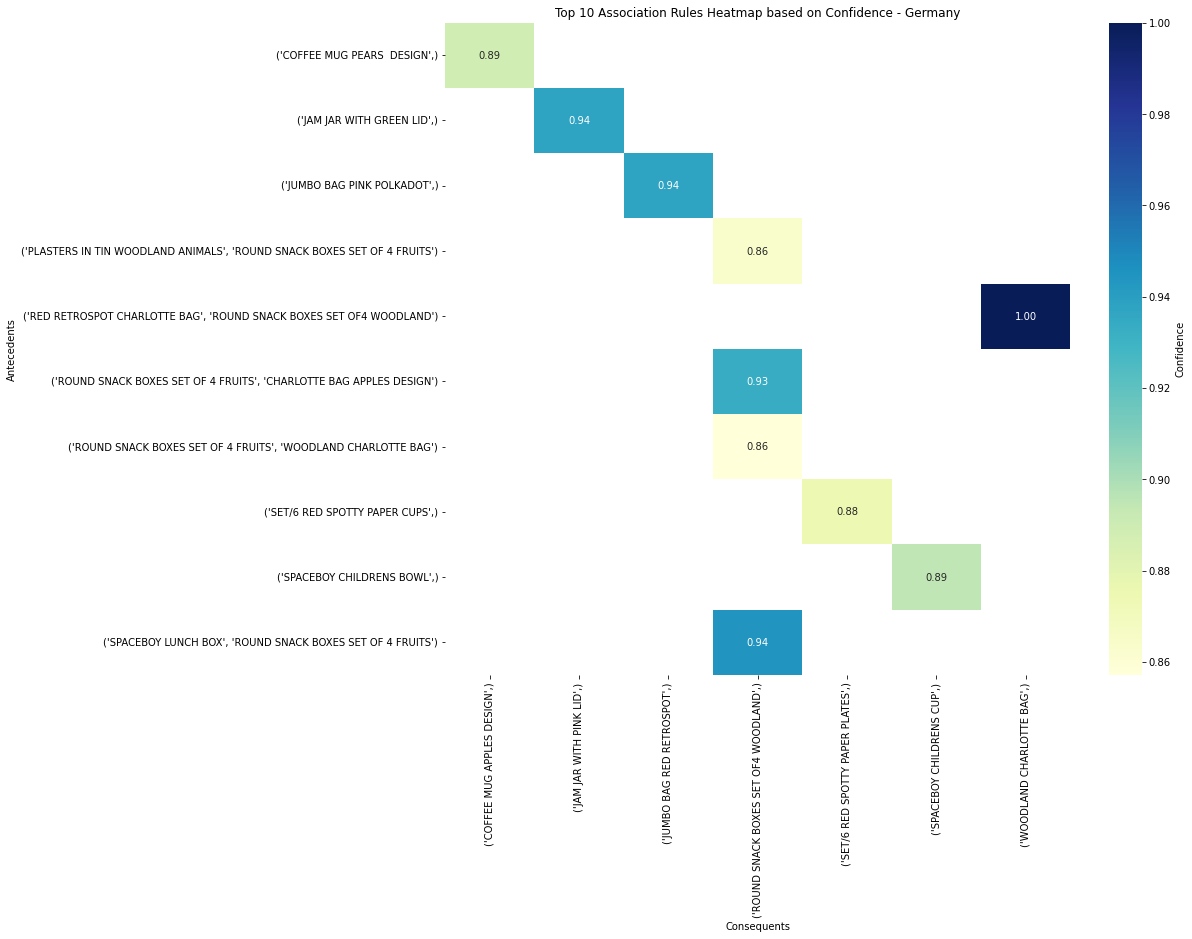

In [0]:

plot_heatmap(germany_rules_df_apriori, 'Germany')


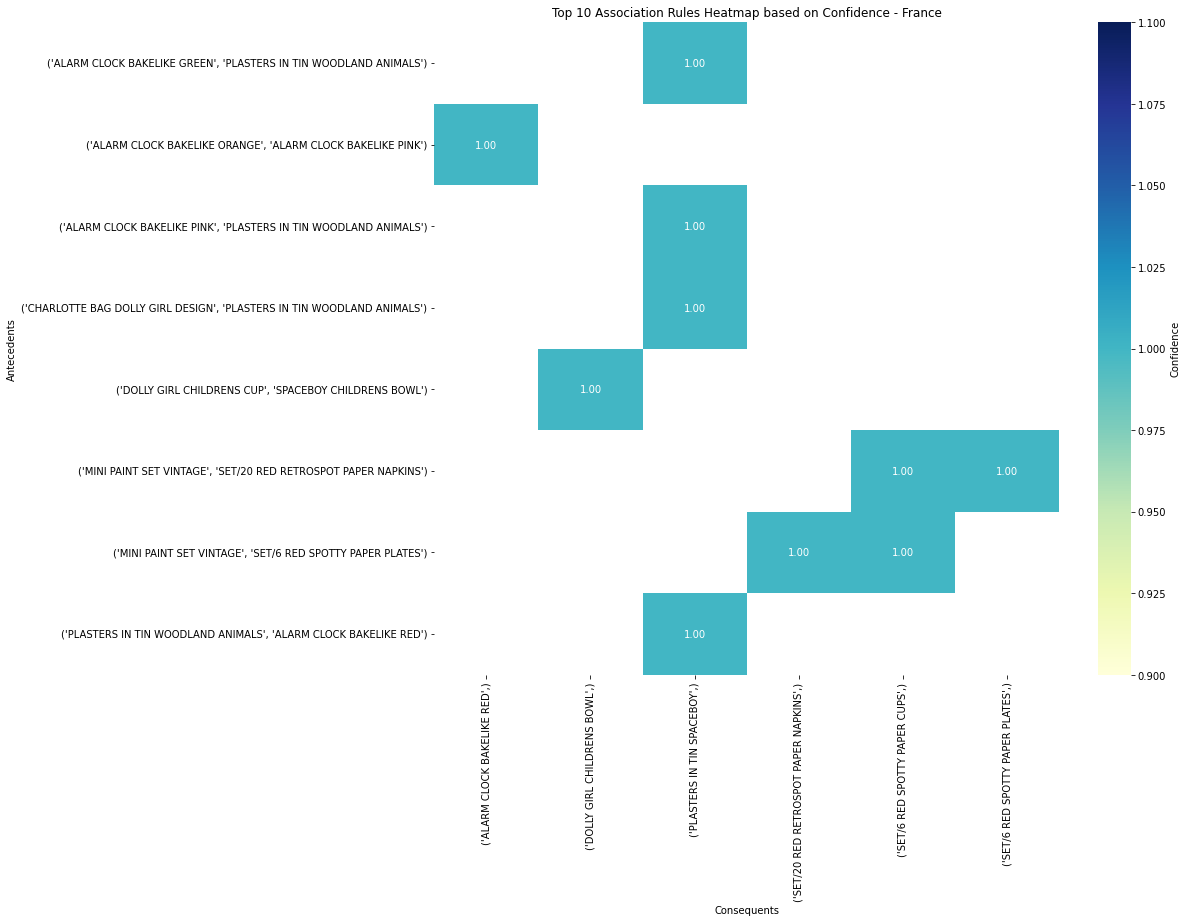

In [0]:

plot_heatmap(france_rules_df_apriori, 'France')